In [1]:
import numpy as np
from skimage import io, exposure, filters, transform, img_as_ubyte
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import hyperspy.api as hs
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# read the emd file:
emd_file = Path("example_images/Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.emd")
emd_obj = hs.load(emd_file)
img_data = emd_obj.data

In [3]:
def get_pixel_size(emd_obj)->float:
    """Convenience function for getting the pixel size form the MASSIVE metadata tree from hyperspys signal objects.
    Careful: In the metadata tree all values are save as string. Therefore converting to float.

    Args:
        emd_obj (hyperspy signal datatype): The data loaded form an .emd file via hyperspy

    Returns:
        float: the px size in meter
    """

    px_height = float(emd_obj.original_metadata.BinaryResult.PixelSize.height)
    px_width = float(emd_obj.original_metadata.BinaryResult.PixelSize.width)

    if px_height == px_width:
        px_size = px_height
    else:
        px_size = (px_height, px_width)
    

    return px_size

px_size = get_pixel_size(emd_obj)

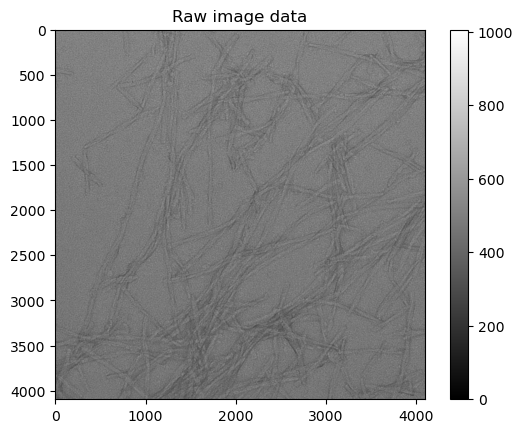

In [4]:
plt.figure()
plt.imshow(img_data, cmap="gray")
plt.title("Raw image data")
plt.colorbar()

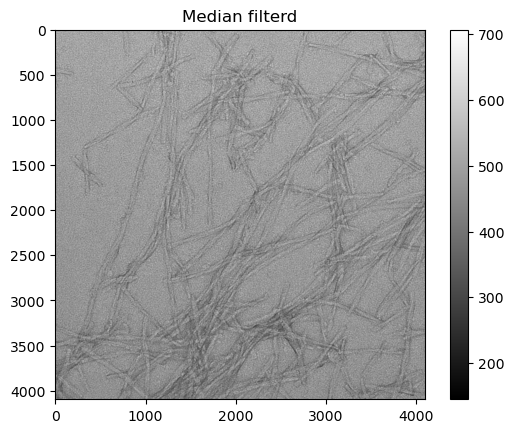

In [5]:
img_data = filters.median(img_data)

plt.figure()
plt.imshow(img_data, cmap="gray")
plt.title("Median filterd")
plt.colorbar()

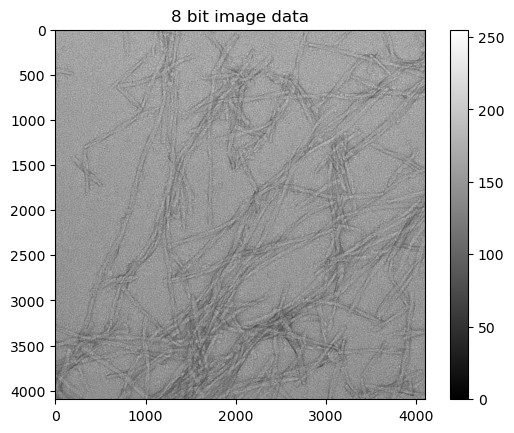

In [6]:
# convert to 8 bit for png conversion:
def convert_to_8bit(img_array:np.ndarray)->np.ndarray:
    """Convert image array to 8 bit for export to png

    Args:
        img_array (np.ndarray): _description_

    Returns:
        np.ndarray: _description_
    """

    return img_as_ubyte(exposure.rescale_intensity(img_array))


img_data_8bit = convert_to_8bit(img_data)

plt.figure()
plt.imshow(img_data_8bit, cmap="gray")
plt.title("8 bit image data")
plt.colorbar()

In [7]:
# downscale the image

downscale_factor = 0.5
img_data_8bit_downscaled = transform.rescale(img_data_8bit, scale=downscale_factor, anti_aliasing=True)
img_data_8bit_downscaled = convert_to_8bit(img_data_8bit_downscaled)
print(f"Size of image scaled by {downscale_factor}:", img_data_8bit_downscaled.shape)
px_size_downscaled = px_size / downscale_factor

img_data_8bit_downscaled

Size of image scaled by 0.5: (2048, 2048)


array([[138, 138, 139, ..., 141, 142, 144],
       [180, 180, 180, ..., 136, 141, 155],
       [207, 207, 208, ..., 125, 147, 174],
       ...,
       [176, 176, 176, ..., 145, 145, 145],
       [165, 165, 165, ..., 141, 138, 133],
       [160, 160, 160, ..., 116, 110, 121]], dtype=uint8)

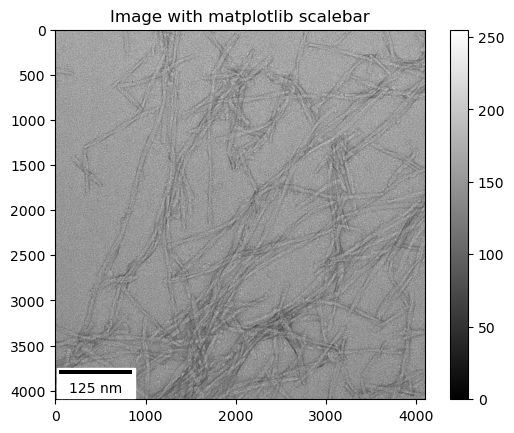

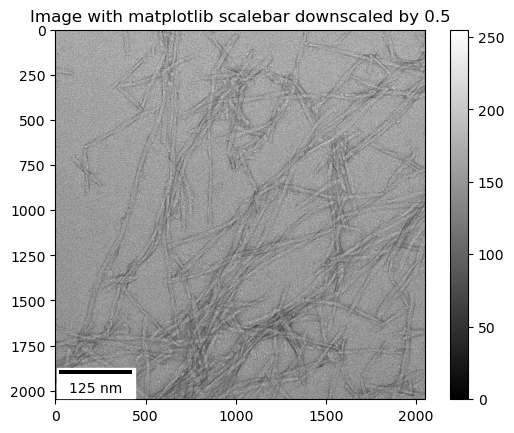

In [8]:
# White text with black border doesn't work with matplotlib scalbar artist

scalebar = ScaleBar(
    dx=px_size,
    units="m",
    location="lower left",
    frameon=True,
    color="black",
)

plt.figure()
plt.imshow(img_data_8bit, cmap="gray")
plt.title("Image with matplotlib scalebar")
plt.colorbar()
ax = plt.gca()
artist = ax.add_artist(scalebar)
plt.show()

scalebar = ScaleBar(
    dx=px_size_downscaled,
    units="m",
    location="lower left",
    frameon=True,
    color="black",
)

plt.figure()
plt.imshow(img_data_8bit_downscaled, cmap="gray")
plt.title(f"Image with matplotlib scalebar downscaled by {downscale_factor}")
plt.colorbar()
ax = plt.gca()
artist = ax.add_artist(scalebar)
plt.show()

In [9]:
# convert px size to sensible unit

def converted_px_size_and_unit(px_size_meter, img_data):
    """Convert pixel size in meter to meter, mm, µm, nm, or, pm and also return the corresponding length unit.

    Args:
        px_size (_type_): _description_
        img_data (_type_): _description_

    Returns:
        _type_: _description_
    """

    im_size_x = img_data.shape[1]
    fov_x = im_size_x * px_size_meter

    units = np.array(["m", "mm", "µm", "nm", "pm"])
    scales = np.array([1e0, 1e-3, 1e-6, 1e-9, 1e-12])

    frac = fov_x / scales

    greater_one = frac >= 1
    smaller_1000 = frac < 1e3

    scale_indicator = np.logical_and(greater_one, smaller_1000)
    assert scale_indicator.any()

    unit = units[scale_indicator][0]

    scale = scales[scale_indicator][0]

    px_size_val = px_size_meter / scale

    return px_size_val, unit


px_size_conv, unit = converted_px_size_and_unit(px_size_downscaled, img_data_8bit_downscaled)
print(f"Px size: {px_size_conv} {unit} ")

Px size: 0.31059690731544176 nm 


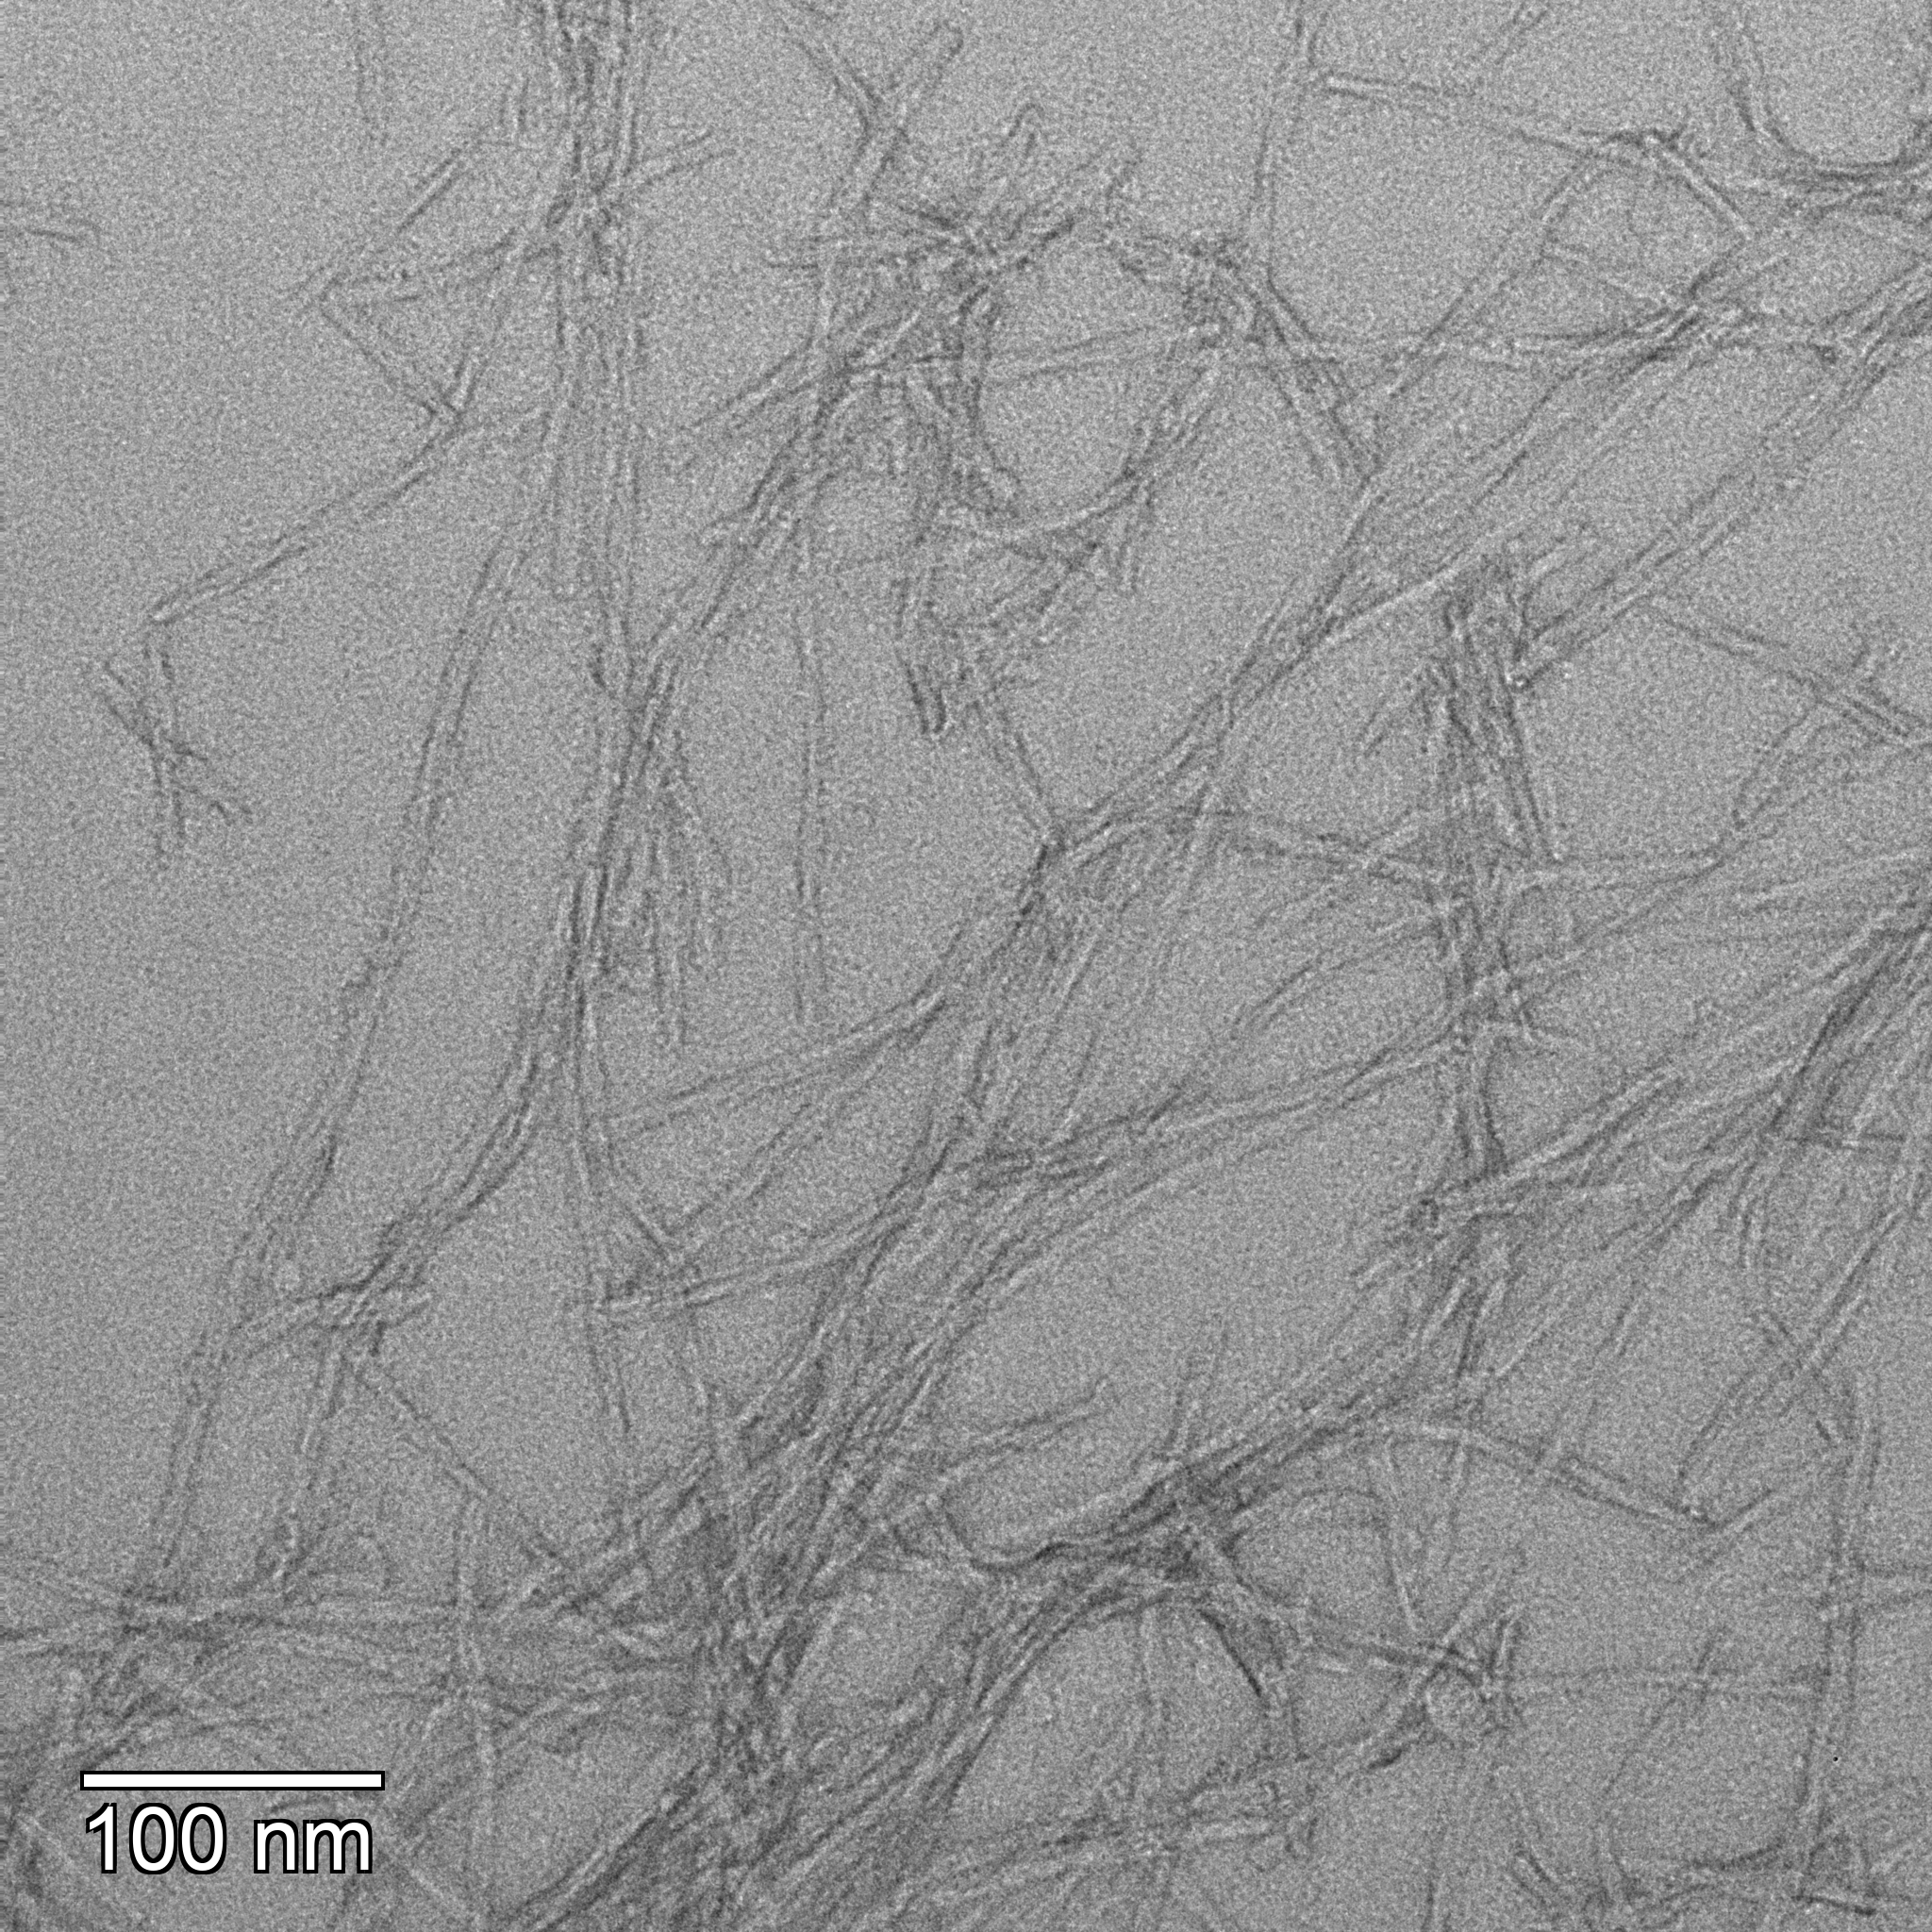

In [10]:
# Add scalebar manually without using matplotlib artists:

def add_scalebar(im, img_data:np.ndarray, px_size_meter:float):

    ## Adding text not really working

    global im_size_x
    im_size_x = img_data.shape[1]
    im_size_y = img_data.shape[0]

    # convert px size from meter to e.g. nm:
    px_size_conv, unit = converted_px_size_and_unit(px_size_meter, img_data)
    fov_x = im_size_x * px_size_conv
    

    # Find a good integer length for the scalebar 
    sb_len_float = fov_x / 6 #Scalebar length is about 1/6 of FOV
    # A list of allowed lengths for the scalebar (in whatever value unit has)
    sb_lst = [0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000,2000,5000]
    # Find the closest value in the list
    sb_len = sorted(sb_lst, key=lambda a: abs(a - sb_len_float))[0]
    sb_len_px = sb_len / px_size_conv
    sb_start_x, sb_start_y = (im_size_x / 24, im_size_y *11 / 12) #Bottom left corner from 1/12 of FOV
    sb_width = im_size_y / 100
    draw = ImageDraw.Draw(im)
    sb = (sb_start_x, sb_start_y, sb_start_x + sb_len_px, sb_start_y + sb_width)
    outline_width = round(im_size_y/500)
    if outline_width == 0:
        outline_width = 1
    draw.rectangle(sb, fill = 'white', outline = 'black', width = outline_width)
    # Add text
    text = f"{sb_len} {unit}"
    fontsize = int(im_size_x / 22)
    try: 
        font = ImageFont.truetype("arial.ttf", fontsize)
    except:
        try: 
            font = ImageFont.truetype("Helvetica.ttc", fontsize)
        except:
            font = ImageFont.load_default()
    # txt_x, txt_y = (sb_start_x * 1.2, sb_start_y + fontsize * 1.2 + sb_width)
    txt_x, txt_y = (sb_start_x, sb_start_y + sb_width)
    # Add outline to the text
    draw.text((txt_x-outline_width, txt_y-outline_width), text, font=font, fill='black')
    draw.text((txt_x+outline_width, txt_y-outline_width), text, font=font, fill='black')
    draw.text((txt_x-outline_width, txt_y+outline_width), text, font=font, fill='black')
    draw.text((txt_x+outline_width, txt_y+outline_width), text, font=font, fill='black')
    # draw the text in white color:
    draw.text((txt_x, txt_y), text, fill='white', font=font, anchor=None)

im = Image.fromarray(img_data_8bit_downscaled)
add_scalebar(im, img_data_8bit_downscaled, px_size_meter=px_size_downscaled)
im

In [11]:
save_dest = emd_file.parent / Path(f"{emd_file.stem}.png")
im.save(save_dest)

In [12]:
def convert_to_png(emd_file):

    # read the emd file:
    emd_file = Path("example_images/Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.emd")
    print(f"Converting {emd_file.name}")
    
    emd_obj = hs.load(emd_file)
    img_data = emd_obj.data

    px_size = get_pixel_size(emd_obj)

    # reduce noise via median filter:
    img_data = filters.median(img_data)

    img_data = convert_to_8bit(img_data)

    # downscale the image:
    downscale_factor = 0.5
    img_data = transform.rescale(img_data, scale=downscale_factor, anti_aliasing=True)
    img_data = convert_to_8bit(img_data)
    print(f"Size of image scaled by {downscale_factor}:", img_data.shape)
    px_size = px_size / downscale_factor

    # add ad scalebar and save png file:
    im = Image.fromarray(img_data)
    add_scalebar(im, img_data, px_size_meter=px_size_downscaled)
    save_dest = emd_file.parent / Path(f"{emd_file.stem}.png")
    im.save(save_dest)

convert_to_png(emd_file)

Converting Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.emd
Size of image scaled by 0.5: (2048, 2048)


In [13]:
def convert_to_png(emd_file):

    # read the emd file:
    emd_file = Path("example_images/Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.emd")
    print(f"Converting {emd_file.name}")
    
    emd_obj = hs.load(emd_file)
    img_data = emd_obj.data

    px_size = get_pixel_size(emd_obj)

    # reduce noise via median filter:
    img_data = filters.median(img_data)

    img_data = convert_to_8bit(img_data)

    # downscale the image:
    downscale_factor = 0.5
    img_data = transform.rescale(img_data, scale=downscale_factor, anti_aliasing=True)
    img_data = convert_to_8bit(img_data)
    print(f"Size of image scaled by {downscale_factor}:", img_data.shape)
    px_size = px_size / downscale_factor

    # add ad scalebar and save png file:
    im = Image.fromarray(img_data)
    add_scalebar(im, img_data, px_size_meter=px_size_downscaled)
    save_dest = emd_file.parent / Path(f"{emd_file.stem}.png")
    print(f"Writing png file (down-)scaled by {downscale_factor} to {save_dest.name}")
    im.save(save_dest)

convert_to_png(emd_file)

Converting Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.emd
Size of image scaled by 0.5: (2048, 2048)
Writing png file (down-)scaled by 0.5 to Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.png


(2048, 2048)


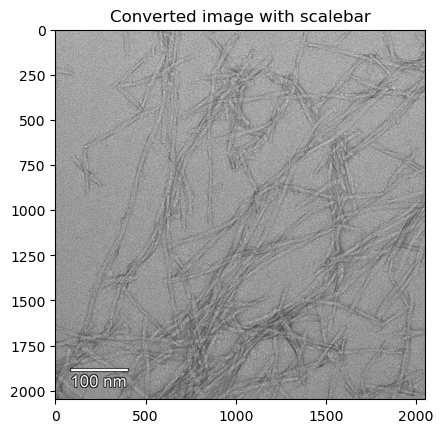

In [14]:
test = io.imread("example_images/Grid_2Q-Abeta_control_2nd_trial 20221017 1156 92000 x.png")
print(test.shape)
plt.figure()
plt.title("Converted image with scalebar")
plt.imshow(test, cmap="gray")